In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
import PIL
import pathlib

2021-12-09 22:16:17.786480: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/google/chrome:/opt/google/chrome/lib
2021-12-09 22:16:17.786500: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Where the data is. although we don't use it when splitting data. more info in the splitting section below.
data_dir = pathlib.Path("./images/modified/")

In [3]:
# Number of images in this folder.
image_count = len(list(data_dir.glob('*.png')))
image_count

1000

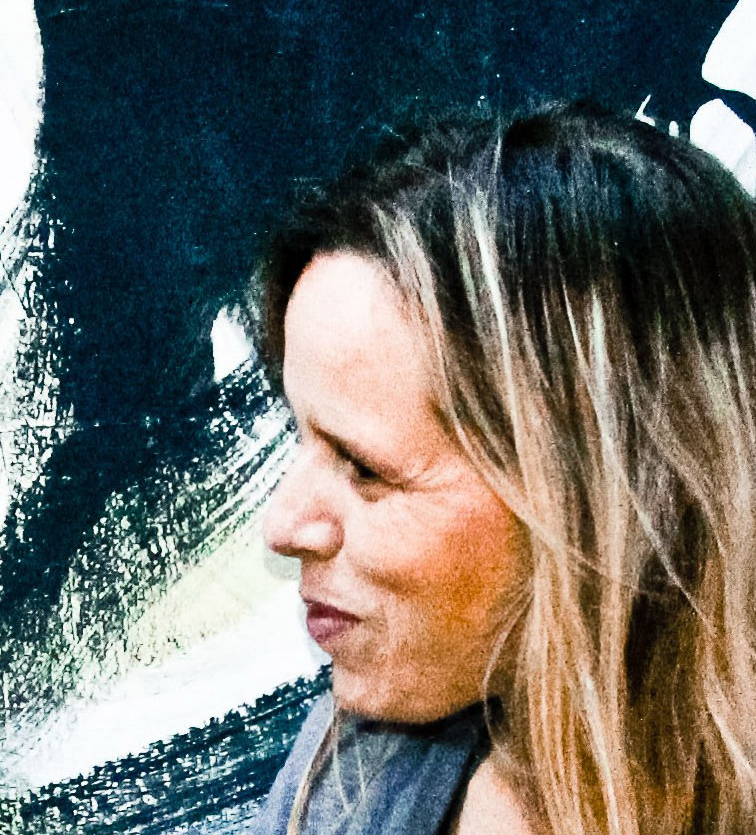

In [4]:
# Look at one picture.
images = list(data_dir.glob('flickr_*.png'))
PIL.Image.open(str(images[10]))

In [5]:
# Set up some params for splitting data
batch_size = 32
img_height = 180
img_width = 180

In [6]:
# Some of these params are self-explantory, but directory should be one level above. (not the one that contains images. the one above it).
# It automatically resizes the images for us (resizing info specificed above).
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory="./images/",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2002 files belonging to 2 classes.
Using 1602 files for training.


2021-12-09 22:16:19.679761: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/google/chrome:/opt/google/chrome/lib
2021-12-09 22:16:19.679783: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-09 22:16:19.679800: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2021-12-09 22:16:19.680016: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Same thing for our validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory="./images/",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2002 files belonging to 2 classes.
Using 400 files for validation.


In [8]:
# We're trying to classify between modified images and original images.
classname = train_ds.class_names
classname

['modified', 'original']

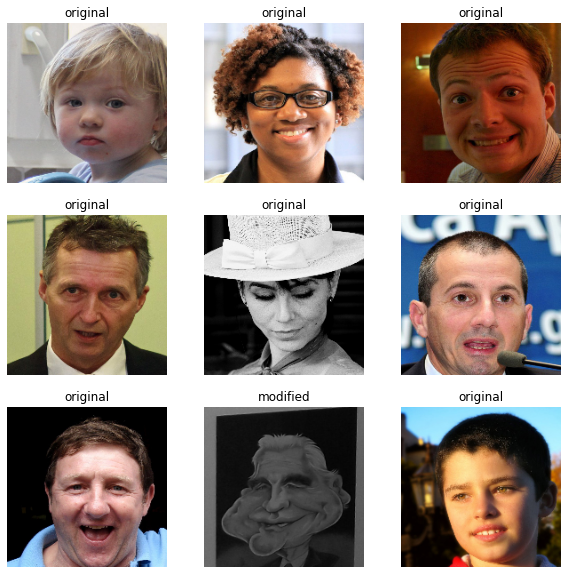

In [9]:
# Visualizing 9 pictures from our training dataset
# (Code from tensorflow tutorial)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classname[labels[i]])
    plt.axis("off")

In [10]:
# Configure the dataset for performance (According to TensorFlow, this removes blocking when doing File I/O) 
# Probably should bnot care too much, but we should use this from now on.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# Create a model
# num_classes -> number of things we want to classify. Here is between original and photoshopped
# layers.Rescaling is good because we don't have to do the manual image normalization ( divide by 255)
num_classes = len(classname)

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='softmax'),
    layers.Dense(num_classes)
])

In [12]:
# Compile the model
# Things that we can try:
# using optimizer different than adam
# sparse categorical crossentropy is kind of a must when doing image classification
# but categorical crossentropy is also used for one hot encoded dataset.
# metris -> I think accuracy makes the most sense.
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Summary of the model
# Basically just what layers it has and all.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [14]:
# Train with 5 epochs
history =  model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5


2021-12-09 22:16:33.743854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 22 of 1000
2021-12-09 22:16:41.460974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


51/51 [==============================] - 41s 443ms/step - loss: 0.7179 - accuracy: 0.5044 - val_loss: 0.6931 - val_accuracy: 0.4900
Epoch 2/5
51/51 [==============================] - 18s 358ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.4900
Epoch 3/5
51/51 [==============================] - 19s 372ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.4900
Epoch 4/5
51/51 [==============================] - 18s 360ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.4900
Epoch 5/5
51/51 [==============================] - 19s 370ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.4900


In [15]:
# This basically flipping the image around or inverting it to create new images
# Goal: make our model more generalized and reduce over-fitting
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

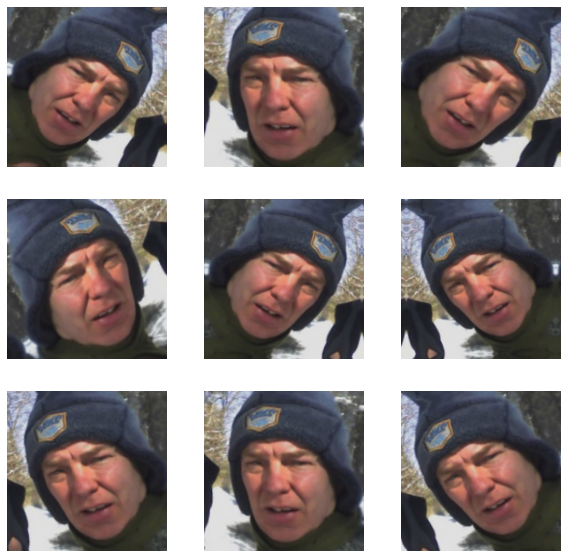

In [16]:
# Examples of data augmentation of images 
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [17]:
# New model with drop-out and data_augmentation
model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128, activation='softmax'),
    layers.Dense(num_classes)
])

In [18]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
51/51 [==============================] - 20s 375ms/step - loss: 0.6935 - accuracy: 0.4875 - val_loss: 0.6933 - val_accuracy: 0.4900
Epoch 2/10
51/51 [==============================] - 19s 366ms/step - loss: 0.6933 - accuracy: 0.4919 - val_loss: 0.6933 - val_accuracy: 0.4900
Epoch 3/10
51/51 [==============================] - 20s 402ms/step - loss: 0.6934 - accuracy: 0.5006 - val_loss: 0.6930 - val_accuracy: 0.5025
Epoch 4/10
51/51 [==============================] - 20s 401ms/step - loss: 0.6944 - accuracy: 0.4988 - val_loss: 0.6930 - val_accuracy: 0.5100
Epoch 5/10
51/51 [==============================] - 20s 396ms/step - loss: 0.6934 - accuracy: 0.4925 - val_loss: 0.6933 - val_accuracy: 0.4900
Epoch 6/10
51/51 [==============================] - 20s 399ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.5100
Epoch 7/10
51/51 [==============================] - 20s 391ms/step - loss: 0.6933 - accuracy: 0.4856 - val_loss: 0.6933 - val_accuracy: 0.4900

In [ ]:
# After doing a bunch more things, we still get the same val_accuracy :D 
# And even worse accuracy than previous

# But in theory, if we have large enough data, then doing drop out and all should increase performance.
# 2000 images is not that big though. 